In [1]:
import gym
import os
import random
import time
import cv2
import copy
import numpy as np
import collections
import matplotlib.pyplot as plt
import json
import scipy
import argparse
from PIL import Image
from collections import deque
from tqdm import tqdm
import ray

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
import torchvision as tv
from torch.utils.data import Dataset


from src.common.atari_wrappers import wrap_deepmind, make_atari
from src.common.utils import LinearSchedule, DataLoaderX, DataPrefetcher, ReplayDataset
from src.common.vec_env import ShmemVecEnv, VecEnvWrapper, DummyVecEnv
from src.agents.model import NatureCNN

In [2]:
ray.init()

2020-08-02 20:52:01,427	INFO resource_spec.py:212 -- Starting Ray with 229.44 GiB memory available for workers and up to 102.34 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-08-02 20:52:01,686	WARNING services.py:923 -- Redis failed to start, retrying now.
2020-08-02 20:52:01,967	INFO services.py:1165 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '192.168.1.154',
 'raylet_ip_address': '192.168.1.154',
 'redis_address': '192.168.1.154:6379',
 'object_store_address': '/tmp/ray/session_2020-08-02_20-52-01_423466_16070/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-08-02_20-52-01_423466_16070/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-08-02_20-52-01_423466_16070'}

In [3]:
game = "Breakout"

device = torch.device('cuda:0')
num_env = 8
num_actors = 32
num_gpus = torch.cuda.device_count()
num_cpus = mp.cpu_count()
total_steps = int(1e7)
epoches = 10
update_per_data = 8
replay_size = int(1e6)
exploration_ratio = 0.1
discount = 0.99
batch_size = 512
base_batch_size = 32
lr = 1e-3

target_net_update_freq = 250
exploration_ratio = 0.2
steps_per_epoch = total_steps // epoches 
replay = deque(maxlen=replay_size)

In [4]:
def make_env(game, episode_life=True, clip_rewards=True):
    env = make_atari(f'{game}NoFrameskip-v4')
    env = wrap_deepmind(env, episode_life=episode_life, clip_rewards=clip_rewards, frame_stack=True, scale=False, transpose_image=True)
    return env

test_env = make_env(game)
state_shape = test_env.observation_space.shape
action_shape = test_env.action_space.n
epsilon_schedule = LinearSchedule(1.0, 0.01, int(epoches * exploration_ratio)) 

model = NatureCNN(state_shape[0], action_shape).to(device)
model_target = copy.deepcopy(model)
optimizer = torch.optim.Adam(model.parameters(), lr)

In [7]:
model.load_state_dict(torch.load('ckpt/e2.pth')['model'])
model_target = copy.deepcopy(model)

In [8]:
@ray.remote
def sampler(rank, epsilon, state_dict):
    envs = ShmemVecEnv([lambda: make_env(game) for _ in range(num_env)], context='fork')
    steps = steps_per_epoch // (num_env * num_actors)
    R = np.zeros(num_env)
    Rs, Qs = [], []
    local_replay = deque(maxlen=replay_size)
    model = NatureCNN(state_shape[0], action_shape)
    model.load_state_dict(state_dict)
    obs = envs.reset()
    tic = time.time()
    for step in range(steps):
        action_random = np.random.randint(0, action_shape, num_env)
        st = torch.from_numpy(np.array(obs)).float() / 255.0
        qs = model(st)
        qs_max, qs_argmax = qs.max(dim=-1)
        action_greedy = qs_argmax.tolist()
        Qs.append(qs_max.mean().item())
        action = [act_grd if p > epsilon else act_rnd for p, act_rnd, act_grd in zip(np.random.rand(num_env), action_random, action_greedy)]

        obs_next, reward, done, info = envs.step(action)
        for entry in zip(obs, action, reward, obs_next, done):
            local_replay.append(entry)
        obs = obs_next
        R += np.array(reward)
        for idx, d in enumerate(done):
            if d:
                Rs.append(R[idx])
                R[idx] = 0
    toc = time.time()
    envs.close()
    print(f"Rank {rank}, Data Collection Time: {toc - tic}, Speed {steps_per_epoch / (toc - tic)}")
    return local_replay, Rs, Qs

In [9]:
# model = torch.nn.DataParallel(model, device_ids=[0,1,2,3])
# model_target = torch.nn.DataParallel(model_target, device_ids=[0,1,2,3])
# data = torch.randn(batch_size, 4, 84, 84).cuda(), torch.rand(batch_size).mul(4.0).long().cuda(), torch.randn(batch_size).cuda(), torch.randn(batch_size, 4, 84, 84).cuda(), torch.randn(batch_size).cuda()

def train(model, model_target):
    dataset = ReplayDataset(replay)
    dataloader = DataLoaderX(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    prefetcher = DataPrefetcher(dataloader, device)
    steps = (steps_per_epoch ) // batch_size
    Ls = []
    model.cuda()
    tic = time.time()
    for step in range(steps):
        try:
            data = prefetcher.next()
        except:
            prefetcher = DataPrefetcher(dataloader, device)
            data = prefetcher.next()

        states, actions, rewards, next_states, terminals = data
        states = states.float() / 255.0
        next_states = next_states.float() / 255.0
        actions = actions.long()
        terminals = terminals.float()
        rewards = rewards.float()

        with torch.no_grad():
            q_next = model_target(next_states)
            q_next_online = model(next_states)
            q_next = q_next.gather(1, q_next_online.argmax(dim=-1).unsqueeze(-1)).squeeze(-1)
            q_target = rewards + discount * (1 - terminals) * q_next

        q = model(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
        loss = F.smooth_l1_loss(q, q_target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        Ls.append(loss.item())
        if step % target_net_update_freq == 0:
            model_target.load_state_dict(model.state_dict())
    toc = time.time()
    print("Loss", np.mean(Ls), np.std(Ls), np.max(Ls))
    print("Epoch Time", toc - tic)
    return model, model_target, Ls

In [10]:
def test(model):
    tic = time.time()
    num_test_envs = 8
    test_envs = ShmemVecEnv([lambda: make_env(game) for _ in range(num_test_envs)], context='fork')

    E = 0
    R = np.zeros(num_test_envs)
    obs = test_envs.reset()
    Rs = []
    while True:
        obs = torch.from_numpy(np.array(obs)).to(device).float().div(255.0)
        action = model(obs).argmax(dim=-1).tolist()
        obs_next, reward, done, info = test_envs.step(action)
        obs = obs_next
        R += np.array(reward)
        for idx, d in enumerate(done):
            if d:
                Rs.append(R[idx])
                R[idx] = 0
                E += 1
        if E > 300:
            break
    test_envs.close()
    toc = time.time()
    print("Test Reward", np.mean(Rs), np.std(Rs), np.max(Rs))
    print("Epoch Time", toc - tic)
    return Rs

In [11]:
LLs, QQs, RRs, TRRs = [], [], [], []

In [12]:
# Sampling
epoch = 2
epsilon = 0.1
print("Epoch", epoch, "Epsilon", epsilon)
datas = ray.get([sampler.remote(rank, epsilon, model.cpu().state_dict()) for rank in range(num_actors)])
Rs, Qs = [], []
for lp, rs, qs in datas:
    replay.extend(lp)
    Rs += rs
    Qs += qs
    del lp
    del rs
    del qs
print("Training Reward", np.mean(Rs), np.std(Rs), np.max(Rs))
print("Training Q", np.mean(Qs), np.std(Qs), np.max(Qs))
RRs += Rs
QQs += Qs
del datas
print("=" * 100)
print(" " * 100)

for epoch in range(1):
    print("=" * 100)
    print("=" * 100)
    print(" " * 100)

    
    for step in range(15):
        ## Training
        model, model_target, Ls = train(model, model_target)
        LLs += Ls
        ## Testing
        TRs = test(model)
        TRRs += TRs
    # torch.save({'model': model.state_dict(), 'loss': LLs, 'Train EPR': RRs, 'Test EPR': TRRs}, f'ckpt/e{epoch}.pth')
    print(" " * 100)
    print("=" * 100)
    print("=" * 100)


Epoch 2 Epsilon 0.1


/home/bzhou/miniconda3/lib/python3.6/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


(pid=16237) Logging to /tmp/openai-2020-08-02-20-53-01-898921
(pid=16237) Creating dummy env object to get spaces
(pid=16232) Logging to /tmp/openai-2020-08-02-20-53-01-932782
(pid=16232) Creating dummy env object to get spaces
(pid=16223) Logging to /tmp/openai-2020-08-02-20-53-01-941590
(pid=16223) Creating dummy env object to get spaces
(pid=16219) Logging to /tmp/openai-2020-08-02-20-53-01-947381
(pid=16219) Creating dummy env object to get spaces
(pid=16221) Logging to /tmp/openai-2020-08-02-20-53-01-977353
(pid=16221) Creating dummy env object to get spaces
(pid=16217) Logging to /tmp/openai-2020-08-02-20-53-01-967172
(pid=16217) Creating dummy env object to get spaces
(pid=16215) Logging to /tmp/openai-2020-08-02-20-53-01-978058
(pid=16215) Creating dummy env object to get spaces
(pid=16229) Logging to /tmp/openai-2020-08-02-20-53-01-995344
(pid=16229) Creating dummy env object to get spaces
(pid=16243) Logging to /tmp/openai-2020-08-02-20-53-02-003617
(pid=16243) Creating dummy

In [32]:
torch.save({'model': model.state_dict(), 'loss': LLs, 'Train EPR': RRs, 'Test EPR': TRRs}, f'ckpt/e{2}.pth')

In [15]:
from scipy.signal import savgol_filter
plt.style.use('ggplot')
plt.figure(figsize=(12, 9), dpi=300)

<Figure size 3600x2700 with 0 Axes>

<Figure size 3600x2700 with 0 Axes>

In [28]:
len(replay)

999936

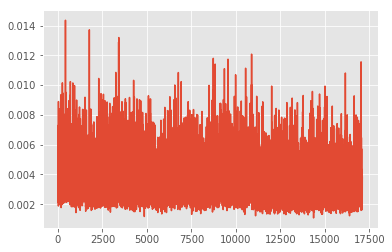

In [30]:
# plt.plot(savgol_filter(LLs, 11, 2)[500:])
plt.plot(LLs[20000:])

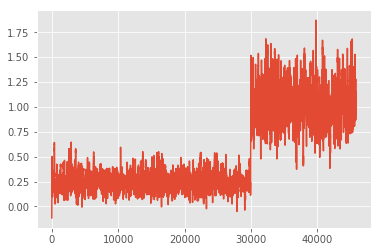

In [25]:
plt.plot(savgol_filter(RRss + RRs, 101, 2))

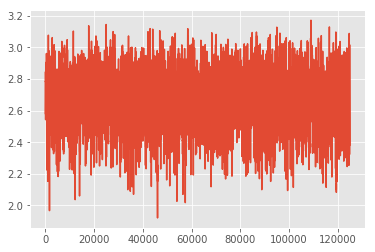

In [18]:
plt.plot(savgol_filter(QQs, 101, 2))

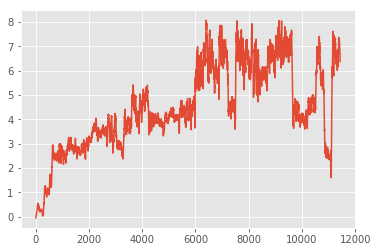

In [31]:
plt.plot(savgol_filter(TTRss + TRRs, 101, 2))

In [23]:
TTRss = torch.load('ckpt/e1.pth')['Test EPR']
LLss = torch.load('ckpt/e1.pth')['loss']
RRss = torch.load('ckpt/e1.pth')['Train EPR'] 